In [1]:
import time, os, sys, pickle, h5py, importlib, gc, copy, re, itertools, json, logging
os.environ['OMP_NUM_THREADS'] = '8'
os.environ['MKL_NUM_THREADS'] = '8'
os.environ['NUMEXPR_NUM_THREADS'] = '8'
from tqdm.auto import tqdm, trange
from pathlib import Path
from util import config_logger

import numpy as np, pandas as pd, scipy
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score

from umap import UMAP

import torch
torch.set_num_threads(16)

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("white")
%matplotlib inline
%config InlineBackend.figure_format='retina'

logger = config_logger(logging.getLogger(__name__))

# Part 1. Run SpiceMix

We provide two approaches to apply SpiceMix to a dataset: 1) in the command line, and 2) through a notebook.

## Part 1.1. Run SpiceMix via the command line
Below is an example to run SpiceMix via the command line. This is just for completeness. We recommand to run these commands in a real command line.

```
path2dataset="/work/magroup/tianming/Researches/SpiceMix/version1/data2/Maynard2021"
mkdir -p "$path2dataset/results"
result_filename="$path2dataset/results/SpiceMix.h5"
echo "path to results file = $result_filename"
rm -f $result_filename
time python main.py \
  --path2dataset=$path2dataset -K=10 --lambda_Sigma_x_inv=1e-6 \
  --repli_list="['151673', '151674', '151675', '151676']" --use_spatial="['True']*4" \
  --initialization_method='louvain' \
  --initialization_kwargs="dict(num_pcs=50, n_neighbors=20, num_rs=10, resolution_boundaries=(.5, 2.))" \
  --max_iter=200 --init_NMF_iter=10 --device='cuda:3' --random_seed=0 \
  --result_filename="$result_filename"
```

## Part 1.2. Run SpiceMix in a notebook

Alternatively, you may run SpiceMix in a notebook. An advantage is that you can better monitor the training process. For example, you may run customized code to inspect the learnt latent embeddings every 50 iterations.

In [3]:
# -- specify device
context = dict(device='cuda:3', dtype=torch.float64)
# context = dict(device='cpu', dtype=torch.float64)

# -- specify dataset
path2dataset = Path('/work/magroup/tianming/Researches/SpiceMix/version1/data2/Maynard2021')
repli_list = ['151673', '151674', '151675', '151676']

2022-11-18 12:15:16:INFO:result file = /work/magroup/tianming/Researches/SpiceMix/version1/data2/Maynard2021/results/SpiceMix.h5
2022-11-18 12:15:16:INFO:Loaded 3639 cells and 3194 genes from /work/magroup/tianming/Researches/SpiceMix/version1/data2/Maynard2021/files/expression_151673.pkl
2022-11-18 12:15:16:INFO:Loaded 3673 cells and 3194 genes from /work/magroup/tianming/Researches/SpiceMix/version1/data2/Maynard2021/files/expression_151674.pkl
2022-11-18 12:15:16:INFO:Loaded 3592 cells and 3194 genes from /work/magroup/tianming/Researches/SpiceMix/version1/data2/Maynard2021/files/expression_151675.pkl
2022-11-18 12:15:16:INFO:Loaded 3460 cells and 3194 genes from /work/magroup/tianming/Researches/SpiceMix/version1/data2/Maynard2021/files/expression_151676.pkl
2022-11-18 12:15:16:INFO:Loaded 3194 genes from /work/magroup/tianming/Researches/SpiceMix/version1/data2/Maynard2021/files/genes_151673.txt
2022-11-18 12:15:16:INFO:Loaded 3194 genes from /work/magroup/tianming/Researches/Spic

Louvain clustering: res=1.00e+00:   0%|          | 0/10 [00:00<?, ?it/s]

Louvain clustering: res=1.41e+00:   0%|          | 0/10 [00:00<?, ?it/s]

Louvain clustering: res=1.19e+00:   0%|          | 0/10 [00:00<?, ?it/s]

Louvain clustering: res=1.09e+00:   0%|          | 0/10 [00:00<?, ?it/s]

2022-11-18 12:17:23:INFO:Updating latent states


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:17:34:INFO:Updating model parameters


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:17:35:INFO:Q value = nan
2022-11-18 12:17:36:INFO:Updating latent states


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:17:45:INFO:Updating model parameters


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:17:45:INFO:Q value = nan
2022-11-18 12:17:45:INFO:Updating latent states


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:17:49:INFO:Updating model parameters


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:17:50:INFO:Q value = nan
2022-11-18 12:17:50:INFO:Updating latent states


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:17:52:INFO:Updating model parameters


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:17:52:INFO:Q value = nan
2022-11-18 12:17:52:INFO:Updating latent states


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:17:54:INFO:Updating model parameters


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:17:55:INFO:Q value = nan
2022-11-18 12:17:55:INFO:Updating latent states


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:17:56:INFO:Updating model parameters


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:17:56:INFO:Q value = nan
2022-11-18 12:17:56:INFO:Updating latent states


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:17:58:INFO:Updating model parameters


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:17:58:INFO:Q value = nan
2022-11-18 12:17:58:INFO:Updating latent states


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:17:59:INFO:Updating model parameters


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:17:59:INFO:Q value = nan
2022-11-18 12:17:59:INFO:Updating latent states


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:18:00:INFO:Updating model parameters


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:18:00:INFO:Q value = nan
2022-11-18 12:18:00:INFO:Updating latent states


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:18:01:INFO:Updating model parameters


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:18:01:INFO:Q value = nan
2022-11-18 12:18:01:INFO:Iteration 1
2022-11-18 12:18:01:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:18:44:INFO:Q value = -18213169.73767028
2022-11-18 12:18:44:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:18:49:INFO:Iteration 2
2022-11-18 12:18:49:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:18:59:INFO:Q value = -18211356.90502834
2022-11-18 12:18:59:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:19:03:INFO:Iteration 3
2022-11-18 12:19:03:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:19:17:INFO:Q value = -18209769.901950043
2022-11-18 12:19:17:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:19:21:INFO:Iteration 4
2022-11-18 12:19:21:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:19:38:INFO:Q value = -18207558.845578864
2022-11-18 12:19:38:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:19:42:INFO:Iteration 5
2022-11-18 12:19:42:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:20:14:INFO:Q value = -18204476.445107087
2022-11-18 12:20:14:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:20:21:INFO:Iteration 6
2022-11-18 12:20:21:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:21:10:INFO:Q value = -18200529.233839214
2022-11-18 12:21:10:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:21:15:INFO:Iteration 7
2022-11-18 12:21:15:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:21:53:INFO:Q value = -18196553.600427527
2022-11-18 12:21:53:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:22:00:INFO:Iteration 8
2022-11-18 12:22:00:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:22:36:INFO:Q value = -18192781.113634873
2022-11-18 12:22:36:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:22:48:INFO:Iteration 9
2022-11-18 12:22:48:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:23:41:INFO:Q value = -18187495.23396273
2022-11-18 12:23:41:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:23:50:INFO:Iteration 10
2022-11-18 12:23:50:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:25:21:INFO:Q value = -18182463.771467213
2022-11-18 12:25:22:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:25:35:INFO:Iteration 11
2022-11-18 12:25:35:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:26:03:INFO:Q value = -18180574.89182741
2022-11-18 12:26:03:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:26:09:INFO:Iteration 12
2022-11-18 12:26:09:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:26:40:INFO:Q value = -18179164.898124926
2022-11-18 12:26:40:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:26:49:INFO:Iteration 13
2022-11-18 12:26:49:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:27:08:INFO:Q value = -18177644.824155815
2022-11-18 12:27:08:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:27:23:INFO:Iteration 14
2022-11-18 12:27:23:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:28:01:INFO:Q value = -18175767.574929263
2022-11-18 12:28:01:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:28:12:INFO:Iteration 15
2022-11-18 12:28:12:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:29:07:INFO:Q value = -18173594.72333503
2022-11-18 12:29:07:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:29:24:INFO:Iteration 16
2022-11-18 12:29:24:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:30:00:INFO:Q value = -18171746.19368676
2022-11-18 12:30:00:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:30:14:INFO:Iteration 17
2022-11-18 12:30:14:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:30:38:INFO:Q value = -18170309.13343416
2022-11-18 12:30:38:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:31:03:INFO:Iteration 18
2022-11-18 12:31:04:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:31:24:INFO:Q value = -18168735.914450727
2022-11-18 12:31:24:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:32:20:INFO:Iteration 19
2022-11-18 12:32:20:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:33:09:INFO:Q value = -18166652.303386137
2022-11-18 12:33:09:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:33:55:INFO:Iteration 20
2022-11-18 12:33:55:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:34:52:INFO:Q value = -18164611.973314937
2022-11-18 12:34:53:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:35:26:INFO:Iteration 21
2022-11-18 12:35:26:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:36:04:INFO:Q value = -18163232.47185712
2022-11-18 12:36:04:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:36:37:INFO:Iteration 22
2022-11-18 12:36:37:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:36:57:INFO:Q value = -18162169.93603078
2022-11-18 12:36:57:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:37:27:INFO:Iteration 23
2022-11-18 12:37:27:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:37:40:INFO:Q value = -18161214.56021415
2022-11-18 12:37:40:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:38:30:INFO:Iteration 24
2022-11-18 12:38:30:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:38:47:INFO:Q value = -18160231.311251454
2022-11-18 12:38:47:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:40:02:INFO:Iteration 25
2022-11-18 12:40:02:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:40:23:INFO:Q value = -18159185.898743752
2022-11-18 12:40:23:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:41:26:INFO:Iteration 26
2022-11-18 12:41:26:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:41:48:INFO:Q value = -18158200.95127949
2022-11-18 12:41:48:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:42:29:INFO:Iteration 27
2022-11-18 12:42:29:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:42:49:INFO:Q value = -18157366.26680686
2022-11-18 12:42:49:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:43:18:INFO:Iteration 28
2022-11-18 12:43:18:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:43:36:INFO:Q value = -18156606.969093554
2022-11-18 12:43:36:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:44:07:INFO:Iteration 29
2022-11-18 12:44:07:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:44:22:INFO:Q value = -18155790.251609314
2022-11-18 12:44:22:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:44:51:INFO:Iteration 30
2022-11-18 12:44:51:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:45:07:INFO:Q value = -18154825.037422545
2022-11-18 12:45:08:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:46:18:INFO:Iteration 31
2022-11-18 12:46:18:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:46:32:INFO:Q value = -18153585.13193198
2022-11-18 12:46:32:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:48:02:INFO:Iteration 32
2022-11-18 12:48:02:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:48:14:INFO:Q value = -18152109.293540493
2022-11-18 12:48:14:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:49:40:INFO:Iteration 33
2022-11-18 12:49:40:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:49:55:INFO:Q value = -18150413.921704542
2022-11-18 12:49:55:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:51:14:INFO:Iteration 34
2022-11-18 12:51:14:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:51:33:INFO:Q value = -18148741.888512295
2022-11-18 12:51:33:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:53:12:INFO:Iteration 35
2022-11-18 12:53:12:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:53:34:INFO:Q value = -18147354.39851692
2022-11-18 12:53:34:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:55:11:INFO:Iteration 36
2022-11-18 12:55:11:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:55:36:INFO:Q value = -18146175.989525173
2022-11-18 12:55:36:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:57:11:INFO:Iteration 37
2022-11-18 12:57:11:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:57:45:INFO:Q value = -18145537.180946108
2022-11-18 12:57:45:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 12:59:11:INFO:Iteration 38
2022-11-18 12:59:11:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 12:59:53:INFO:Q value = -18145067.71590962
2022-11-18 12:59:53:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:01:07:INFO:Iteration 39
2022-11-18 13:01:07:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:01:30:INFO:Q value = -18144323.34719459
2022-11-18 13:01:30:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:02:48:INFO:Iteration 40
2022-11-18 13:02:48:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:03:06:INFO:Q value = -18143798.704624526
2022-11-18 13:03:06:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:03:51:INFO:Iteration 41
2022-11-18 13:03:51:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:04:08:INFO:Q value = -18143318.62068923
2022-11-18 13:04:08:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:04:57:INFO:Iteration 42
2022-11-18 13:04:57:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:05:15:INFO:Q value = -18142885.09332685
2022-11-18 13:05:15:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:06:04:INFO:Iteration 43
2022-11-18 13:06:04:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:06:25:INFO:Q value = -18142468.62534175
2022-11-18 13:06:25:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:07:24:INFO:Iteration 44
2022-11-18 13:07:24:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:07:43:INFO:Q value = -18142084.087309007
2022-11-18 13:07:43:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:08:11:INFO:Iteration 45
2022-11-18 13:08:11:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:10:13:INFO:Iteration 47
2022-11-18 13:10:13:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:10:31:INFO:Q value = -18141055.21445893
2022-11-18 13:10:31:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:11:32:INFO:Iteration 48
2022-11-18 13:11:32:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:11:49:INFO:Q value = -18140650.501034148
2022-11-18 13:11:49:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:12:28:INFO:Iteration 49
2022-11-18 13:12:28:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:12:43:INFO:Q value = -18140319.94279667
2022-11-18 13:12:43:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:12:58:INFO:Iteration 50
2022-11-18 13:12:58:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:13:16:INFO:Q value = -18140015.884968236
2022-11-18 13:13:16:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

normalization = z-score


Louvain clustering: res=4.47e-01:   0%|          | 0/20 [00:00<?, ?it/s]

Louvain clustering: res=2.11e-01:   0%|          | 0/20 [00:00<?, ?it/s]

Louvain clustering: res=1.45e-01:   0%|          | 0/20 [00:00<?, ?it/s]

Louvain clustering: res=1.21e-01:   0%|          | 0/20 [00:00<?, ?it/s]

ari all = 0.50
ari 151673 = 0.53
ari 151674 = 0.47
ari 151675 = 0.49
ari 151676 = 0.51


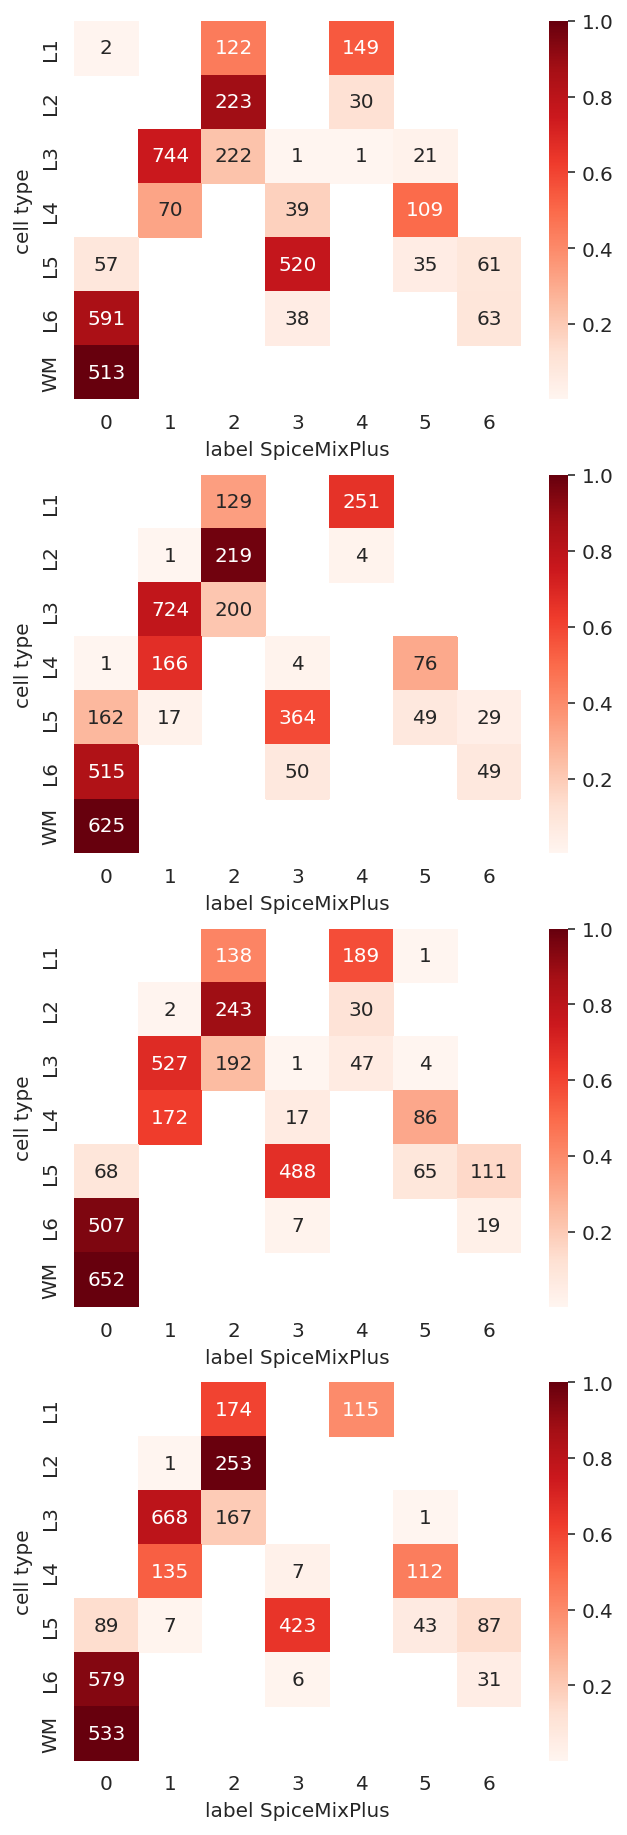

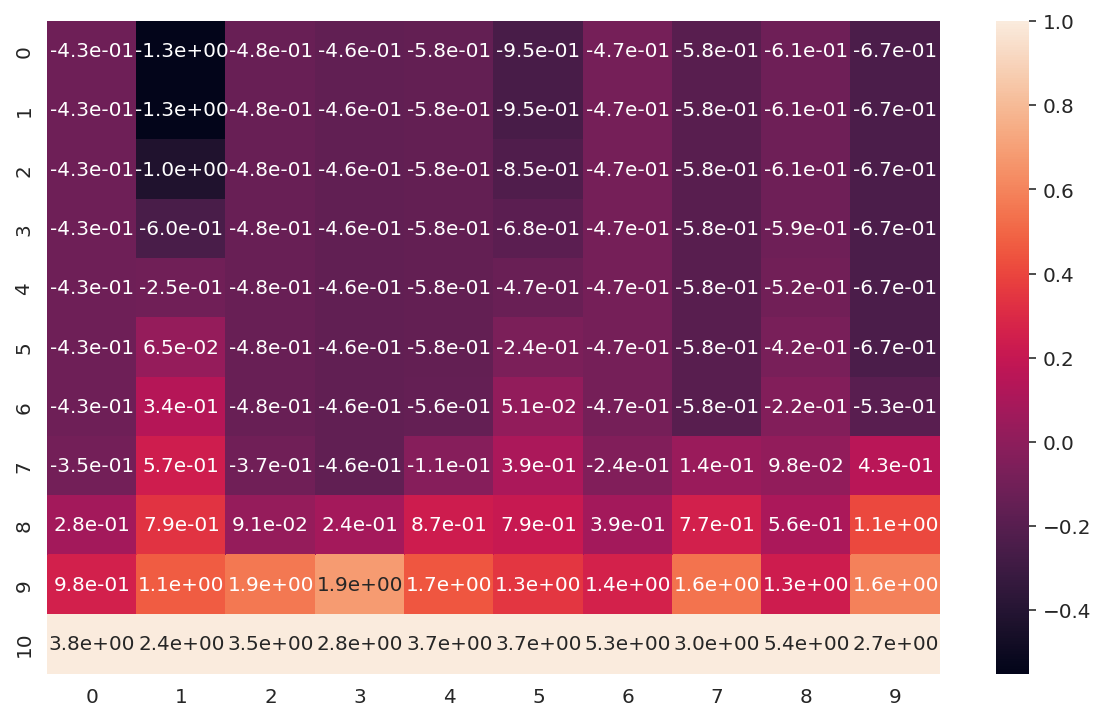

2022-11-18 13:15:47:INFO:Iteration 51
2022-11-18 13:15:47:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:16:02:INFO:Q value = -18139717.15434552
2022-11-18 13:16:02:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:16:30:INFO:Iteration 52
2022-11-18 13:16:30:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:16:49:INFO:Q value = -18139422.44379207
2022-11-18 13:16:49:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:17:32:INFO:Iteration 53
2022-11-18 13:17:32:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:17:47:INFO:Q value = -18139118.764586154
2022-11-18 13:17:47:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:17:53:INFO:Iteration 54
2022-11-18 13:17:53:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:18:09:INFO:Q value = -18138862.997067157
2022-11-18 13:18:09:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:18:12:INFO:Iteration 55
2022-11-18 13:18:12:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:18:30:INFO:Q value = -18138625.20318418
2022-11-18 13:18:30:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:18:32:INFO:Iteration 56
2022-11-18 13:18:32:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:18:50:INFO:Q value = -18138397.48172595
2022-11-18 13:18:50:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:18:51:INFO:Iteration 57
2022-11-18 13:18:51:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:19:09:INFO:Q value = -18138176.306684107
2022-11-18 13:19:09:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:19:10:INFO:Iteration 58
2022-11-18 13:19:10:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:19:28:INFO:Q value = -18137961.64270917
2022-11-18 13:19:28:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:19:30:INFO:Iteration 59
2022-11-18 13:19:30:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:19:49:INFO:Q value = -18137754.408756033
2022-11-18 13:19:49:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:19:50:INFO:Iteration 60
2022-11-18 13:19:50:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:20:09:INFO:Q value = -18137555.658669796
2022-11-18 13:20:09:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:20:12:INFO:Iteration 61
2022-11-18 13:20:12:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:20:29:INFO:Q value = -18137366.335792325
2022-11-18 13:20:29:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:20:30:INFO:Iteration 62
2022-11-18 13:20:30:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:20:48:INFO:Q value = -18137186.78076848
2022-11-18 13:20:48:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:20:50:INFO:Iteration 63
2022-11-18 13:20:50:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:21:05:INFO:Q value = -18137018.213481065
2022-11-18 13:21:05:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:21:06:INFO:Iteration 64
2022-11-18 13:21:06:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:21:23:INFO:Q value = -18136860.90582266
2022-11-18 13:21:23:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:21:24:INFO:Iteration 65
2022-11-18 13:21:24:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:21:40:INFO:Q value = -18136712.971437972
2022-11-18 13:21:40:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:21:41:INFO:Iteration 66
2022-11-18 13:21:41:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:21:57:INFO:Q value = -18136575.61174236
2022-11-18 13:21:57:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:21:58:INFO:Iteration 67
2022-11-18 13:21:58:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:22:14:INFO:Q value = -18136446.709982798
2022-11-18 13:22:14:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:22:15:INFO:Iteration 68
2022-11-18 13:22:15:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:22:30:INFO:Q value = -18136325.756615445
2022-11-18 13:22:30:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:22:31:INFO:Iteration 69
2022-11-18 13:22:31:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:22:46:INFO:Q value = -18136211.78574803
2022-11-18 13:22:46:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:22:47:INFO:Iteration 70
2022-11-18 13:22:47:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:23:03:INFO:Q value = -18136104.5997766
2022-11-18 13:23:03:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:23:06:INFO:Iteration 71
2022-11-18 13:23:06:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:23:22:INFO:Q value = -18136003.551085014
2022-11-18 13:23:22:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:23:23:INFO:Iteration 72
2022-11-18 13:23:23:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:23:42:INFO:Q value = -18135905.767654113
2022-11-18 13:23:42:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:23:43:INFO:Iteration 73
2022-11-18 13:23:43:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:23:59:INFO:Q value = -18135812.816454202
2022-11-18 13:23:59:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:24:01:INFO:Iteration 74
2022-11-18 13:24:01:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:24:17:INFO:Q value = -18135721.601990044
2022-11-18 13:24:17:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:24:18:INFO:Iteration 75
2022-11-18 13:24:18:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:24:34:INFO:Q value = -18135633.005385306
2022-11-18 13:24:34:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:24:35:INFO:Iteration 76
2022-11-18 13:24:35:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:24:51:INFO:Q value = -18135546.073699318
2022-11-18 13:24:51:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:24:52:INFO:Iteration 77
2022-11-18 13:24:52:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:25:11:INFO:Q value = -18135461.163414806
2022-11-18 13:25:11:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:25:13:INFO:Iteration 78
2022-11-18 13:25:13:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:25:32:INFO:Q value = -18135378.417769846
2022-11-18 13:25:32:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:25:34:INFO:Iteration 79
2022-11-18 13:25:34:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:25:53:INFO:Q value = -18135297.20889945
2022-11-18 13:25:53:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:25:55:INFO:Iteration 80
2022-11-18 13:25:55:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:26:11:INFO:Q value = -18135216.511828642
2022-11-18 13:26:11:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:26:12:INFO:Iteration 81
2022-11-18 13:26:12:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:26:29:INFO:Q value = -18135136.542891104
2022-11-18 13:26:29:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:26:30:INFO:Iteration 82
2022-11-18 13:26:30:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:26:49:INFO:Q value = -18135055.590751547
2022-11-18 13:26:49:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:26:50:INFO:Iteration 83
2022-11-18 13:26:50:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:27:10:INFO:Q value = -18134976.085239686
2022-11-18 13:27:10:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:27:12:INFO:Iteration 84
2022-11-18 13:27:12:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:27:32:INFO:Q value = -18134894.09095984
2022-11-18 13:27:32:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:27:33:INFO:Iteration 85
2022-11-18 13:27:33:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:27:51:INFO:Q value = -18134811.834676966
2022-11-18 13:27:51:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:27:53:INFO:Iteration 86
2022-11-18 13:27:53:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:28:07:INFO:Q value = -18134730.398969315
2022-11-18 13:28:07:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:28:08:INFO:Iteration 87
2022-11-18 13:28:08:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:28:24:INFO:Q value = -18134648.239313245
2022-11-18 13:28:24:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:28:25:INFO:Iteration 88
2022-11-18 13:28:25:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:28:39:INFO:Q value = -18134565.117539287
2022-11-18 13:28:39:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:28:40:INFO:Iteration 89
2022-11-18 13:28:40:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:28:55:INFO:Q value = -18134481.594644666
2022-11-18 13:28:55:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:28:57:INFO:Iteration 90
2022-11-18 13:28:57:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:29:11:INFO:Q value = -18134396.987604033
2022-11-18 13:29:11:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:29:13:INFO:Iteration 91
2022-11-18 13:29:13:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:29:29:INFO:Q value = -18134313.112053167
2022-11-18 13:29:29:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:29:30:INFO:Iteration 92
2022-11-18 13:29:30:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:29:45:INFO:Q value = -18134226.419127196
2022-11-18 13:29:45:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:29:46:INFO:Iteration 93
2022-11-18 13:29:46:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:30:00:INFO:Q value = -18134138.865013346
2022-11-18 13:30:00:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:30:01:INFO:Iteration 94
2022-11-18 13:30:01:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:30:17:INFO:Q value = -18134050.246214367
2022-11-18 13:30:17:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:30:19:INFO:Iteration 95
2022-11-18 13:30:19:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:30:36:INFO:Q value = -18133961.431460418
2022-11-18 13:30:36:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:30:37:INFO:Iteration 96
2022-11-18 13:30:37:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:30:53:INFO:Q value = -18133870.361394376
2022-11-18 13:30:53:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:30:54:INFO:Iteration 97
2022-11-18 13:30:54:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:31:09:INFO:Q value = -18133777.80842373
2022-11-18 13:31:09:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:31:10:INFO:Iteration 98
2022-11-18 13:31:10:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:31:24:INFO:Q value = -18133684.870681036
2022-11-18 13:31:24:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:31:26:INFO:Iteration 99
2022-11-18 13:31:26:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:31:40:INFO:Q value = -18133589.5593274
2022-11-18 13:31:40:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:31:41:INFO:Iteration 100
2022-11-18 13:31:41:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:31:55:INFO:Q value = -18133494.24744008
2022-11-18 13:31:56:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

normalization = z-score


Louvain clustering: res=4.47e-01:   0%|          | 0/20 [00:00<?, ?it/s]

Louvain clustering: res=2.11e-01:   0%|          | 0/20 [00:00<?, ?it/s]

Louvain clustering: res=1.45e-01:   0%|          | 0/20 [00:00<?, ?it/s]

ari all = 0.60
ari 151673 = 0.60
ari 151674 = 0.61
ari 151675 = 0.58
ari 151676 = 0.63


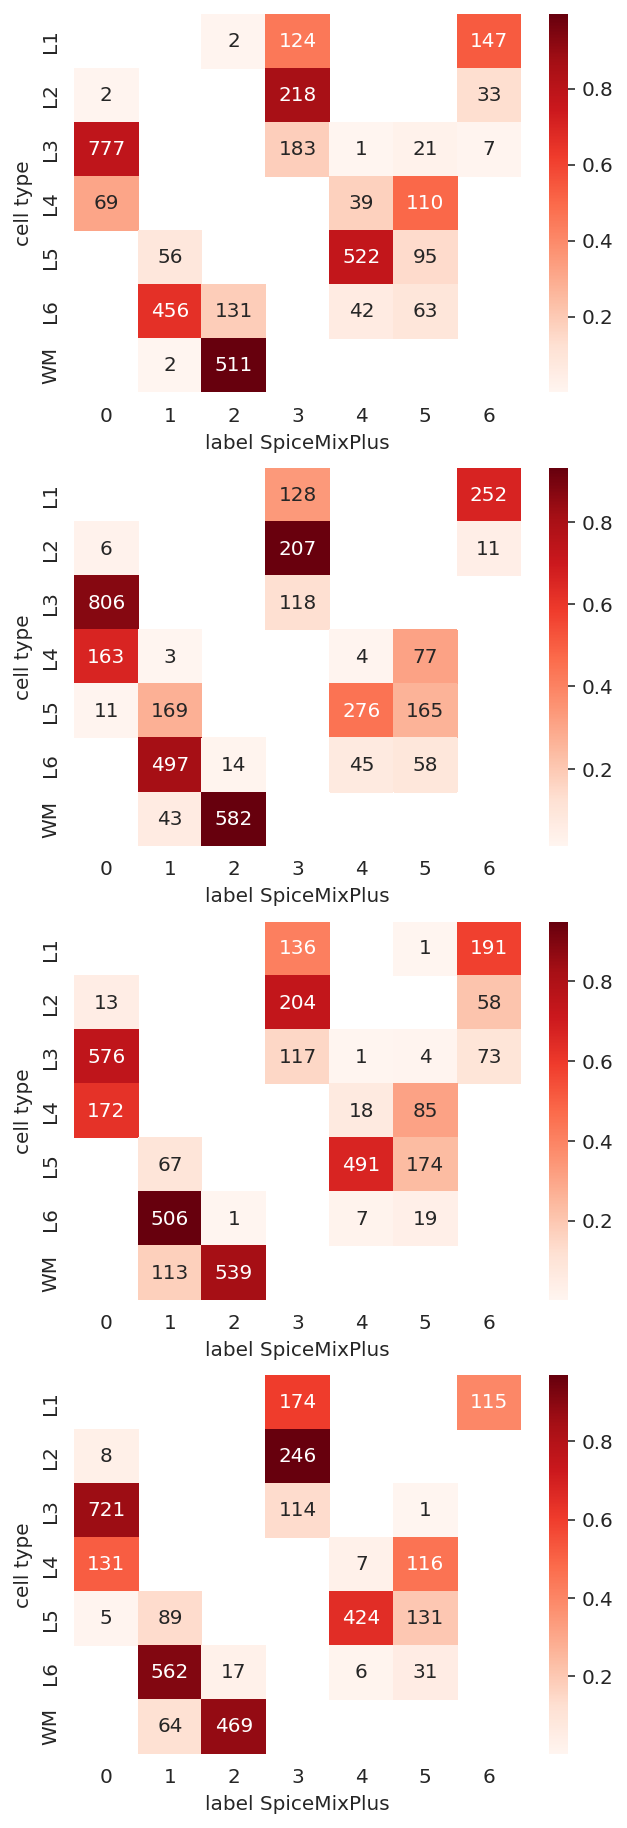

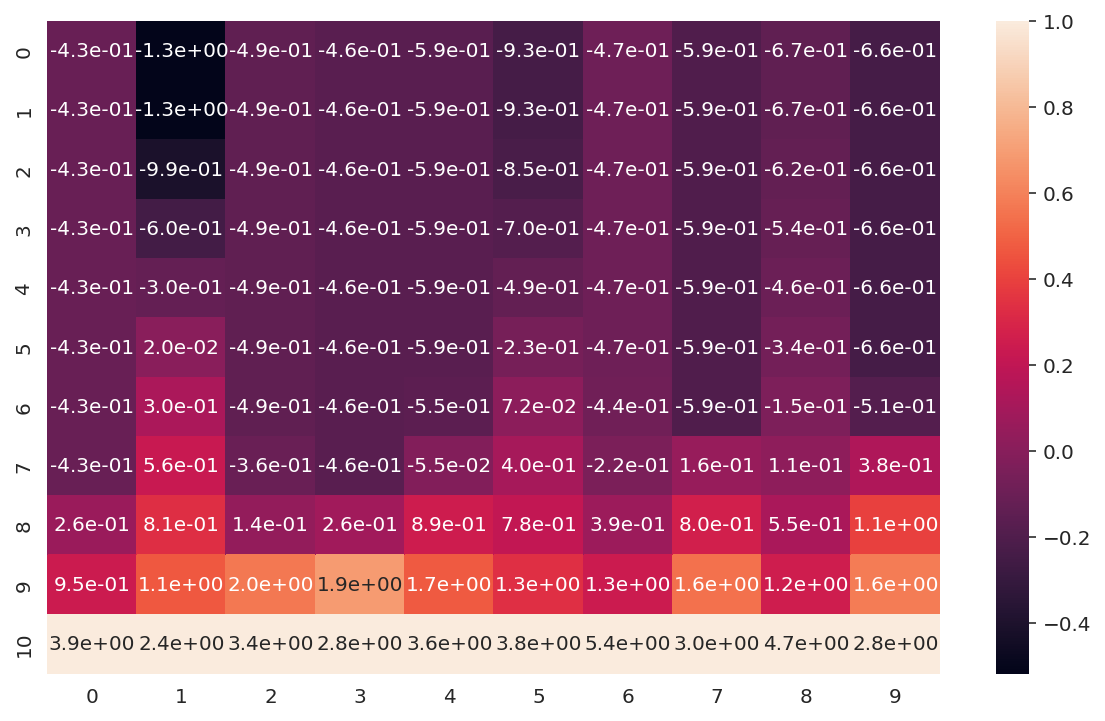

2022-11-18 13:33:22:INFO:Iteration 101
2022-11-18 13:33:22:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:33:38:INFO:Q value = -18133398.196408924
2022-11-18 13:33:38:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:33:39:INFO:Iteration 102
2022-11-18 13:33:39:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:33:54:INFO:Q value = -18133300.284741864
2022-11-18 13:33:54:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:33:55:INFO:Iteration 103
2022-11-18 13:33:55:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:34:13:INFO:Q value = -18133201.304759696
2022-11-18 13:34:13:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:34:15:INFO:Iteration 104
2022-11-18 13:34:15:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:34:35:INFO:Q value = -18133101.69749047
2022-11-18 13:34:35:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:34:36:INFO:Iteration 105
2022-11-18 13:34:36:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:34:54:INFO:Q value = -18132999.56847736
2022-11-18 13:34:54:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:34:55:INFO:Iteration 106
2022-11-18 13:34:55:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:35:09:INFO:Q value = -18132898.01929916
2022-11-18 13:35:09:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:35:10:INFO:Iteration 107
2022-11-18 13:35:10:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:35:24:INFO:Q value = -18132794.024989277
2022-11-18 13:35:24:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:35:25:INFO:Iteration 108
2022-11-18 13:35:25:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:35:39:INFO:Q value = -18132689.72754854
2022-11-18 13:35:39:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:35:40:INFO:Iteration 109
2022-11-18 13:35:40:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:35:54:INFO:Q value = -18132583.94938939
2022-11-18 13:35:54:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:35:55:INFO:Iteration 110
2022-11-18 13:35:55:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:36:09:INFO:Q value = -18132476.689764187
2022-11-18 13:36:09:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:36:10:INFO:Iteration 111
2022-11-18 13:36:10:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:36:24:INFO:Q value = -18132368.4691987
2022-11-18 13:36:24:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:36:25:INFO:Iteration 112
2022-11-18 13:36:25:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:36:39:INFO:Q value = -18132258.973147243
2022-11-18 13:36:39:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:36:41:INFO:Iteration 113
2022-11-18 13:36:41:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:36:55:INFO:Q value = -18132147.14309766
2022-11-18 13:36:55:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:36:56:INFO:Iteration 114
2022-11-18 13:36:56:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:37:12:INFO:Q value = -18132034.890214205
2022-11-18 13:37:12:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:37:13:INFO:Iteration 115
2022-11-18 13:37:13:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:37:26:INFO:Q value = -18131920.335719425
2022-11-18 13:37:26:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:37:27:INFO:Iteration 116
2022-11-18 13:37:27:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:37:41:INFO:Q value = -18131804.111939315
2022-11-18 13:37:41:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:37:42:INFO:Iteration 117
2022-11-18 13:37:42:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:37:56:INFO:Q value = -18131686.1619487
2022-11-18 13:37:56:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:37:57:INFO:Iteration 118
2022-11-18 13:37:57:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:38:11:INFO:Q value = -18131566.961563032
2022-11-18 13:38:11:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:38:12:INFO:Iteration 119
2022-11-18 13:38:12:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:38:26:INFO:Q value = -18131444.490051493
2022-11-18 13:38:26:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:38:27:INFO:Iteration 120
2022-11-18 13:38:27:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:38:41:INFO:Q value = -18131319.98295284
2022-11-18 13:38:41:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:38:43:INFO:Iteration 121
2022-11-18 13:38:43:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:38:56:INFO:Q value = -18131192.63131971
2022-11-18 13:38:56:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:38:57:INFO:Iteration 122
2022-11-18 13:38:57:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:39:11:INFO:Q value = -18131062.260918092
2022-11-18 13:39:11:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:39:12:INFO:Iteration 123
2022-11-18 13:39:12:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:39:27:INFO:Q value = -18130928.701506563
2022-11-18 13:39:27:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:39:28:INFO:Iteration 124
2022-11-18 13:39:28:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:39:46:INFO:Q value = -18130791.157639794
2022-11-18 13:39:46:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:39:47:INFO:Iteration 125
2022-11-18 13:39:47:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:40:02:INFO:Q value = -18130649.177766092
2022-11-18 13:40:02:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:40:04:INFO:Iteration 126
2022-11-18 13:40:04:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:40:17:INFO:Q value = -18130502.708576985
2022-11-18 13:40:17:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:40:18:INFO:Iteration 127
2022-11-18 13:40:18:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:40:33:INFO:Q value = -18130351.318380546
2022-11-18 13:40:33:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:40:34:INFO:Iteration 128
2022-11-18 13:40:34:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:40:49:INFO:Q value = -18130194.657935493
2022-11-18 13:40:49:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:40:50:INFO:Iteration 129
2022-11-18 13:40:50:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:41:05:INFO:Q value = -18130030.896300815
2022-11-18 13:41:05:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:41:06:INFO:Iteration 130
2022-11-18 13:41:06:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:41:22:INFO:Q value = -18129859.667168844
2022-11-18 13:41:22:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:41:24:INFO:Iteration 131
2022-11-18 13:41:24:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:41:42:INFO:Q value = -18129679.70986867
2022-11-18 13:41:42:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:41:44:INFO:Iteration 132
2022-11-18 13:41:44:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:42:01:INFO:Q value = -18129489.93534155
2022-11-18 13:42:01:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:42:03:INFO:Iteration 133
2022-11-18 13:42:03:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:42:20:INFO:Q value = -18129290.172538295
2022-11-18 13:42:20:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:42:21:INFO:Iteration 134
2022-11-18 13:42:21:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:42:39:INFO:Q value = -18129078.177961826
2022-11-18 13:42:39:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:42:40:INFO:Iteration 135
2022-11-18 13:42:40:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:42:59:INFO:Q value = -18128853.08191709
2022-11-18 13:42:59:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:43:00:INFO:Iteration 136
2022-11-18 13:43:00:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:43:22:INFO:Q value = -18128614.100368056
2022-11-18 13:43:22:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:43:23:INFO:Iteration 137
2022-11-18 13:43:23:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:43:45:INFO:Q value = -18128360.343696095
2022-11-18 13:43:45:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:43:46:INFO:Iteration 138
2022-11-18 13:43:46:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:44:10:INFO:Q value = -18128090.474334218
2022-11-18 13:44:10:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:44:12:INFO:Iteration 139
2022-11-18 13:44:12:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:44:36:INFO:Q value = -18127803.12921245
2022-11-18 13:44:36:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:44:37:INFO:Iteration 140
2022-11-18 13:44:37:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:45:05:INFO:Q value = -18127497.372301467
2022-11-18 13:45:06:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:45:08:INFO:Iteration 141
2022-11-18 13:45:08:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:45:34:INFO:Q value = -18127186.047727462
2022-11-18 13:45:34:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:45:35:INFO:Iteration 142
2022-11-18 13:45:35:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:45:59:INFO:Q value = -18126888.36991916
2022-11-18 13:45:59:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:46:00:INFO:Iteration 143
2022-11-18 13:46:00:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:46:21:INFO:Q value = -18126617.14377789
2022-11-18 13:46:21:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:46:23:INFO:Iteration 144
2022-11-18 13:46:23:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:46:42:INFO:Q value = -18126378.810277063
2022-11-18 13:46:42:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:46:43:INFO:Iteration 145
2022-11-18 13:46:43:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:47:01:INFO:Q value = -18126169.63310819
2022-11-18 13:47:01:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:47:02:INFO:Iteration 146
2022-11-18 13:47:02:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:47:18:INFO:Q value = -18125984.2016004
2022-11-18 13:47:18:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:47:19:INFO:Iteration 147
2022-11-18 13:47:19:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:47:37:INFO:Q value = -18125815.098589495
2022-11-18 13:47:37:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:47:38:INFO:Iteration 148
2022-11-18 13:47:38:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:47:54:INFO:Q value = -18125659.428984493
2022-11-18 13:47:54:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:47:56:INFO:Iteration 149
2022-11-18 13:47:56:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:48:10:INFO:Q value = -18125513.877250653
2022-11-18 13:48:10:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:48:10:INFO:Iteration 150
2022-11-18 13:48:10:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:48:25:INFO:Q value = -18125377.99629028
2022-11-18 13:48:25:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

normalization = z-score


Louvain clustering: res=4.47e-01:   0%|          | 0/20 [00:00<?, ?it/s]

Louvain clustering: res=2.11e-01:   0%|          | 0/20 [00:00<?, ?it/s]

Louvain clustering: res=1.45e-01:   0%|          | 0/20 [00:00<?, ?it/s]

Louvain clustering: res=1.75e-01:   0%|          | 0/20 [00:00<?, ?it/s]

ari all = 0.60
ari 151673 = 0.56
ari 151674 = 0.60
ari 151675 = 0.65
ari 151676 = 0.63


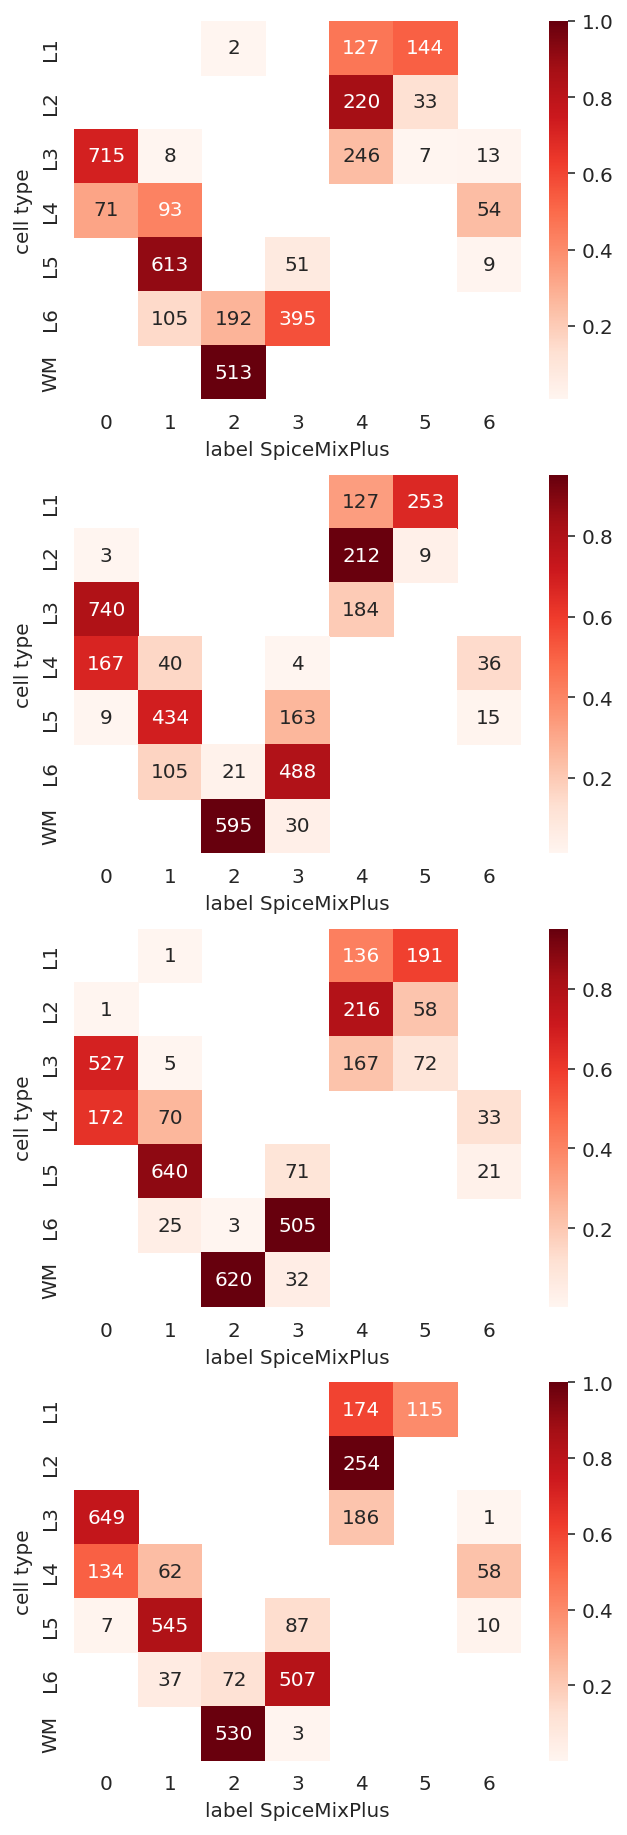

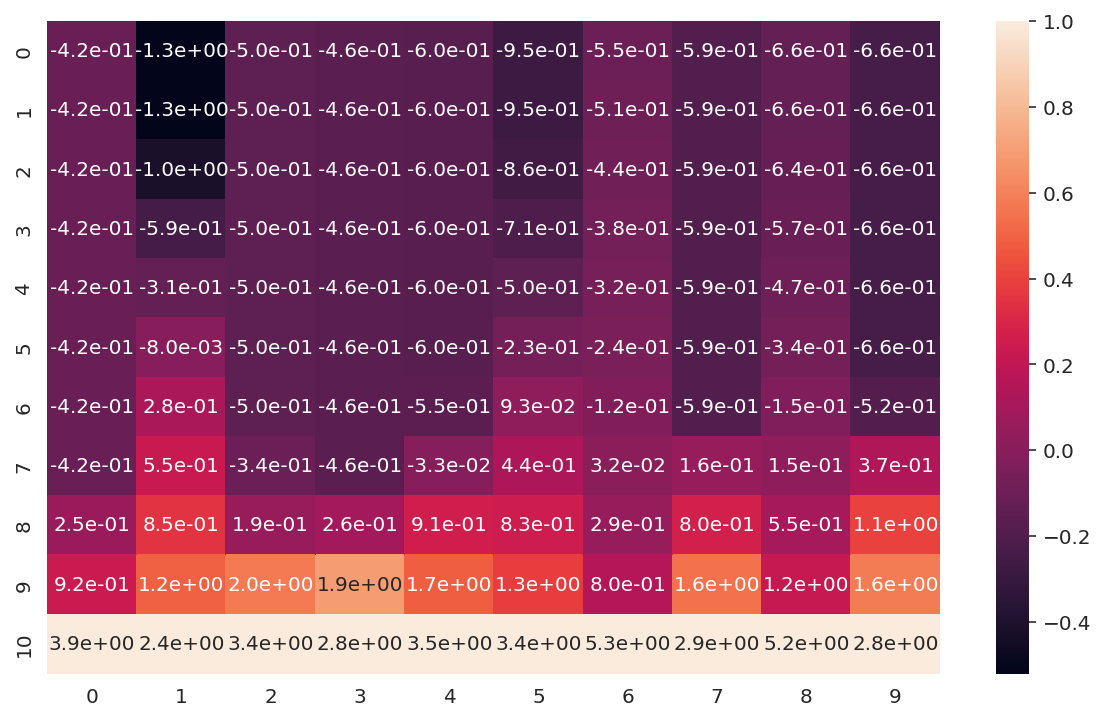

2022-11-18 13:50:45:INFO:Iteration 151
2022-11-18 13:50:45:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:51:00:INFO:Q value = -18125251.72730478
2022-11-18 13:51:00:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:51:00:INFO:Iteration 152
2022-11-18 13:51:00:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:51:16:INFO:Q value = -18125135.119038787
2022-11-18 13:51:16:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:51:17:INFO:Iteration 153
2022-11-18 13:51:17:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:51:34:INFO:Q value = -18125028.62432013
2022-11-18 13:51:34:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:51:34:INFO:Iteration 154
2022-11-18 13:51:34:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:51:50:INFO:Q value = -18124932.28939833
2022-11-18 13:51:50:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:51:51:INFO:Iteration 155
2022-11-18 13:51:51:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:52:08:INFO:Q value = -18124847.254449613
2022-11-18 13:52:08:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:52:08:INFO:Iteration 156
2022-11-18 13:52:08:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:52:24:INFO:Q value = -18124773.94105611
2022-11-18 13:52:24:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:52:25:INFO:Iteration 157
2022-11-18 13:52:25:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:52:41:INFO:Q value = -18124711.156137295
2022-11-18 13:52:41:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:52:41:INFO:Iteration 158
2022-11-18 13:52:41:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:52:57:INFO:Q value = -18124655.37738964
2022-11-18 13:52:57:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:52:58:INFO:Iteration 159
2022-11-18 13:52:58:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:53:15:INFO:Q value = -18124605.489394054
2022-11-18 13:53:15:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:53:15:INFO:Iteration 160
2022-11-18 13:53:15:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:53:31:INFO:Q value = -18124559.404923797
2022-11-18 13:53:32:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:53:35:INFO:Iteration 161
2022-11-18 13:53:35:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:53:52:INFO:Q value = -18124517.217194427
2022-11-18 13:53:52:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:53:52:INFO:Iteration 162
2022-11-18 13:53:52:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:54:09:INFO:Q value = -18124478.641363036
2022-11-18 13:54:09:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:54:09:INFO:Iteration 163
2022-11-18 13:54:09:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:54:23:INFO:Q value = -18124443.452338234
2022-11-18 13:54:23:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:54:23:INFO:Iteration 164
2022-11-18 13:54:23:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:54:38:INFO:Q value = -18124411.588085312
2022-11-18 13:54:38:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:54:38:INFO:Iteration 165
2022-11-18 13:54:38:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:54:52:INFO:Q value = -18124382.794969983
2022-11-18 13:54:52:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:54:53:INFO:Iteration 166
2022-11-18 13:54:53:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:55:07:INFO:Q value = -18124356.8374093
2022-11-18 13:55:07:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:55:07:INFO:Iteration 167
2022-11-18 13:55:07:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:55:21:INFO:Q value = -18124333.66717107
2022-11-18 13:55:21:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:55:21:INFO:Iteration 168
2022-11-18 13:55:21:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:55:35:INFO:Q value = -18124313.116085757
2022-11-18 13:55:35:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:55:36:INFO:Iteration 169
2022-11-18 13:55:36:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:55:49:INFO:Q value = -18124295.10233876
2022-11-18 13:55:49:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:55:50:INFO:Iteration 170
2022-11-18 13:55:50:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:56:04:INFO:Q value = -18124279.36437164
2022-11-18 13:56:04:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:56:06:INFO:Iteration 171
2022-11-18 13:56:06:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:56:21:INFO:Q value = -18124265.833214026
2022-11-18 13:56:21:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:56:22:INFO:Iteration 172
2022-11-18 13:56:22:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:56:37:INFO:Q value = -18124254.240161162
2022-11-18 13:56:37:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:56:37:INFO:Iteration 173
2022-11-18 13:56:37:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:56:51:INFO:Q value = -18124244.495975606
2022-11-18 13:56:51:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:56:52:INFO:Iteration 174
2022-11-18 13:56:52:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:57:09:INFO:Q value = -18124236.37989138
2022-11-18 13:57:09:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:57:10:INFO:Iteration 175
2022-11-18 13:57:10:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:57:26:INFO:Q value = -18124229.685685836
2022-11-18 13:57:26:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:57:26:INFO:Iteration 176
2022-11-18 13:57:26:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:57:42:INFO:Q value = -18124224.384712297
2022-11-18 13:57:42:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:57:42:INFO:Iteration 177
2022-11-18 13:57:42:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:57:57:INFO:Q value = -18124220.465982307
2022-11-18 13:57:57:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:57:58:INFO:Iteration 178
2022-11-18 13:57:58:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:58:12:INFO:Q value = -18124217.78142617
2022-11-18 13:58:12:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:58:13:INFO:Iteration 179
2022-11-18 13:58:13:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:58:28:INFO:Q value = -18124216.23279589
2022-11-18 13:58:28:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:58:29:INFO:Iteration 180
2022-11-18 13:58:29:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:58:44:INFO:Q value = -18124215.764415894
2022-11-18 13:58:44:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:58:44:INFO:Iteration 181
2022-11-18 13:58:44:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:58:59:INFO:Q value = -18124216.443461034
2022-11-18 13:58:59:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:58:59:INFO:Iteration 182
2022-11-18 13:58:59:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:59:13:INFO:Q value = -18124218.173956923
2022-11-18 13:59:13:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:59:14:INFO:Iteration 183
2022-11-18 13:59:14:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:59:29:INFO:Q value = -18124220.8306163
2022-11-18 13:59:29:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:59:29:INFO:Iteration 184
2022-11-18 13:59:29:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 13:59:49:INFO:Q value = -18124224.27044196
2022-11-18 13:59:49:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 13:59:49:INFO:Iteration 185
2022-11-18 13:59:49:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 14:00:09:INFO:Q value = -18124228.3938753
2022-11-18 14:00:09:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 14:00:09:INFO:Iteration 186
2022-11-18 14:00:09:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 14:00:27:INFO:Q value = -18124233.131717518
2022-11-18 14:00:27:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 14:00:27:INFO:Iteration 187
2022-11-18 14:00:27:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 14:00:42:INFO:Q value = -18124238.51143188
2022-11-18 14:00:42:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 14:00:43:INFO:Iteration 188
2022-11-18 14:00:43:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 14:00:57:INFO:Q value = -18124244.48551662
2022-11-18 14:00:57:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 14:00:57:INFO:Iteration 189
2022-11-18 14:00:57:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 14:01:12:INFO:Q value = -18124250.98751535
2022-11-18 14:01:12:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 14:01:12:INFO:Iteration 190
2022-11-18 14:01:12:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 14:01:26:INFO:Q value = -18124258.023958623
2022-11-18 14:01:26:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 14:01:28:INFO:Iteration 191
2022-11-18 14:01:28:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 14:01:42:INFO:Q value = -18124265.525180455
2022-11-18 14:01:42:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 14:01:43:INFO:Iteration 192
2022-11-18 14:01:43:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 14:01:58:INFO:Q value = -18124273.432507418
2022-11-18 14:01:58:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 14:01:59:INFO:Iteration 193
2022-11-18 14:01:59:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 14:02:17:INFO:Q value = -18124281.71611375
2022-11-18 14:02:17:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 14:02:18:INFO:Iteration 194
2022-11-18 14:02:18:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 14:02:37:INFO:Q value = -18124290.394204218
2022-11-18 14:02:37:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 14:02:38:INFO:Iteration 195
2022-11-18 14:02:38:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 14:02:57:INFO:Q value = -18124299.504340667
2022-11-18 14:02:57:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 14:02:57:INFO:Iteration 196
2022-11-18 14:02:57:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 14:03:12:INFO:Q value = -18124309.040920585
2022-11-18 14:03:12:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 14:03:13:INFO:Iteration 197
2022-11-18 14:03:13:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 14:03:27:INFO:Q value = -18124318.952604793
2022-11-18 14:03:27:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 14:03:27:INFO:Iteration 198
2022-11-18 14:03:27:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 14:03:41:INFO:Q value = -18124329.24328973
2022-11-18 14:03:41:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 14:03:42:INFO:Iteration 199
2022-11-18 14:03:42:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 14:04:00:INFO:Q value = -18124339.843538966
2022-11-18 14:04:00:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

2022-11-18 14:04:01:INFO:Iteration 200
2022-11-18 14:04:01:INFO:Updating model parameters


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-11-18 14:04:20:INFO:Q value = -18124350.737402845
2022-11-18 14:04:22:INFO:Updating latent states


Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

normalization = z-score


Louvain clustering: res=4.47e-01:   0%|          | 0/20 [00:00<?, ?it/s]

Louvain clustering: res=2.11e-01:   0%|          | 0/20 [00:00<?, ?it/s]

Louvain clustering: res=1.45e-01:   0%|          | 0/20 [00:00<?, ?it/s]

Louvain clustering: res=1.75e-01:   0%|          | 0/20 [00:00<?, ?it/s]

ari all = 0.64
ari 151673 = 0.64
ari 151674 = 0.63
ari 151675 = 0.66
ari 151676 = 0.69


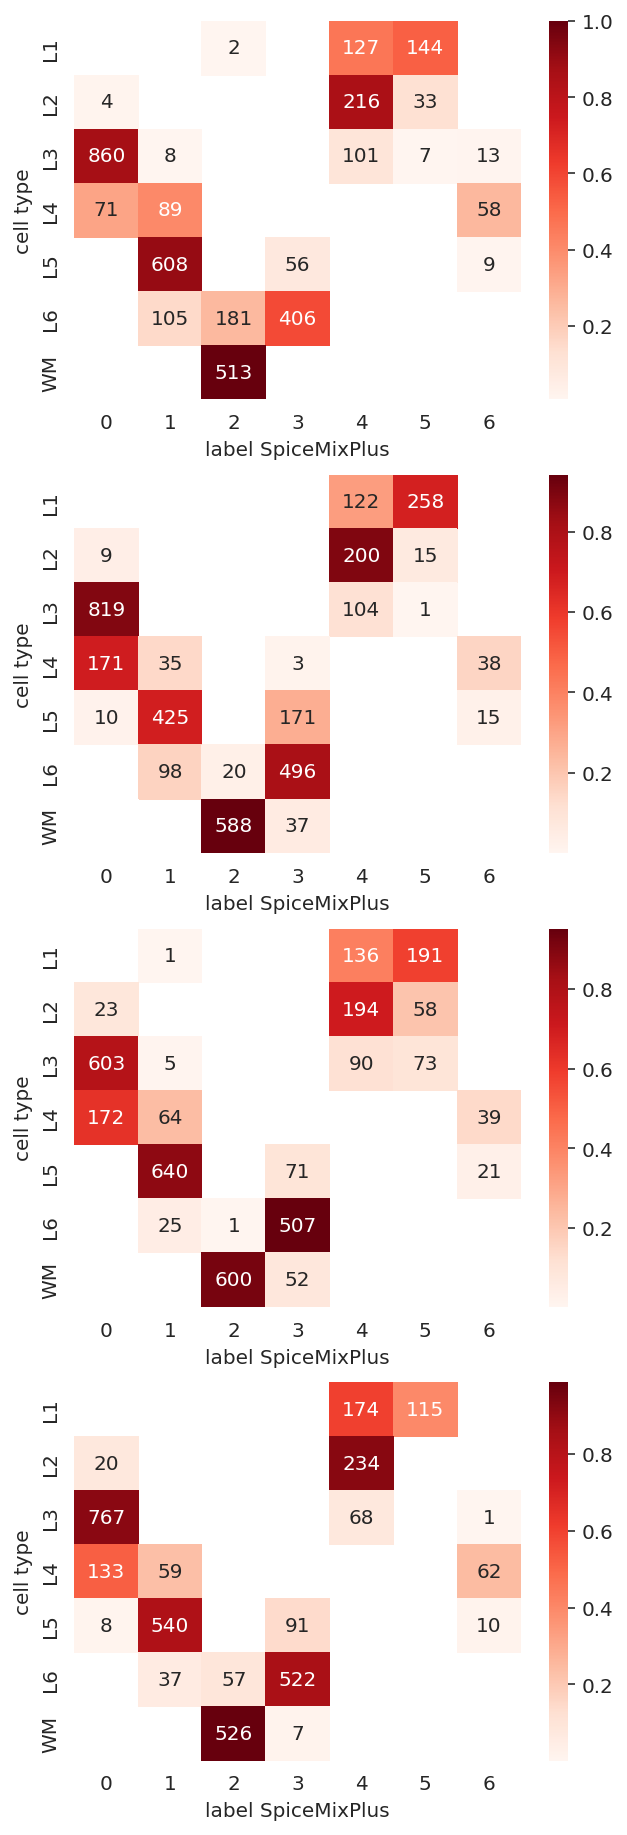

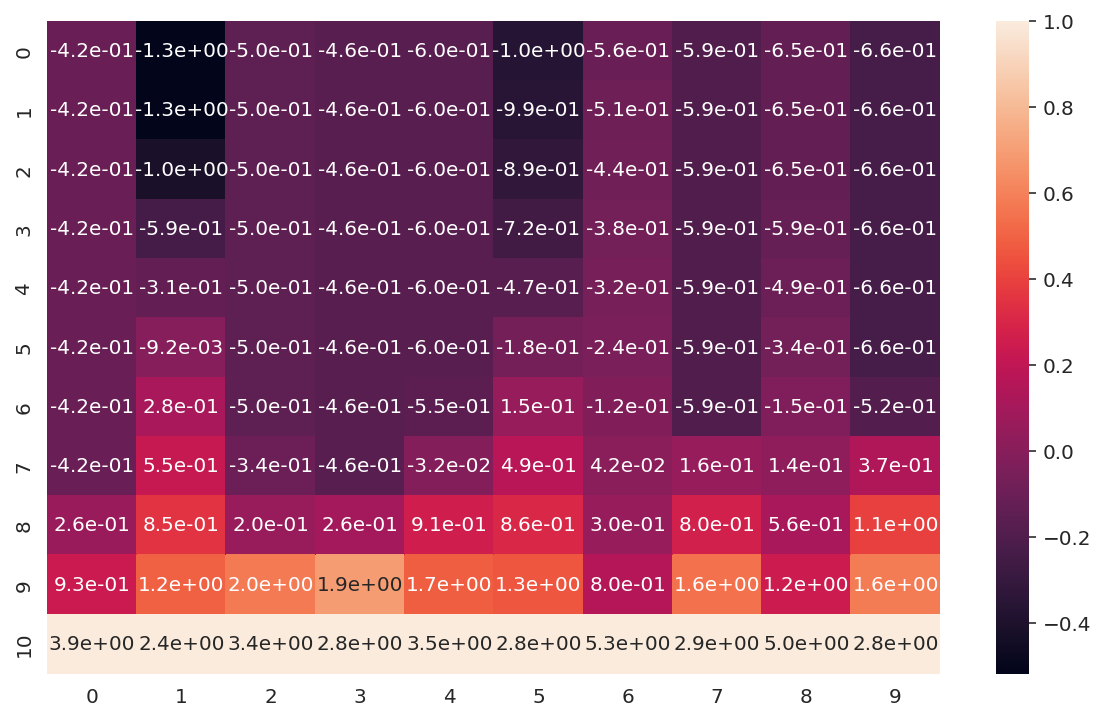

In [4]:
from model import SpiceMix
from helper import evaluate_embedding_maynard2021 # This function is for the optional on-the-fly evaluation. This is not required for SpiceMix.
fn_eval = evaluate_embedding_maynard2021

np.random.seed(0)

K, num_pcs, n_neighbors, res_lo, res_hi = 10, 50, 20, .5, 2.

path2result = path2dataset / 'results' / 'SpiceMix.h5'
os.makedirs(path2result.parent, exist_ok=True)
if os.path.exists(path2result):
    os.remove(path2result)

obj = SpiceMix(
    K=10,
    lambda_Sigma_x_inv=1e-6, power_Sigma_x_inv=2,
    repli_list=repli_list,
    context=context,
    context_Y=context,
    path2result=path2result,
)
obj.load_dataset(path2dataset)
obj.meta['cell type'] = pd.Categorical(obj.meta['cell type'])
# --
obj.initialize(
    method='louvain', kwargs=dict(num_pcs=num_pcs, n_neighbors=n_neighbors, resolution_boundaries=(res_lo, res_hi), num_rs=10),
)
for iiter in range(10):
    obj.estimate_weights(iiter=iiter, use_spatial=[False]*obj.num_repli)
    obj.estimate_parameters(iiter=iiter, use_spatial=[False]*obj.num_repli)
obj.initialize_Sigma_x_inv()
for iiter in range(1, 201):
    logger.info(f'Iteration {iiter}')
    obj.estimate_parameters(iiter=iiter, use_spatial=[True]*obj.num_repli)
    obj.estimate_weights(iiter=iiter, use_spatial=[True]*obj.num_repli)
    if iiter % 50 == 0: # Optional
        # We evaluate the learned latent embeddings every 50 iterations
        evaluate_embedding_maynard2021(obj)

# Part 2. Inspect learned model parameters
After fitting SpiceMix to the dataset, SpiceMix learns latent representations for single cells or spots.

In this example notebook, we evaluate learnt latent states by clustering. We use Louvain clustering (an unsupervised clustering algorithm) on the learnt latent space and compare the clusters with the ground-truth annotations. We quantify the consistency by the ARI score.

In [5]:
# -- load meta data
path2dataset = Path('/work/magroup/tianming/Researches/SpiceMix/version1/data2/Maynard2021')
repli_list = ['151673', '151674', '151675', '151676']
df_meta = []
for repli in repli_list:
    df = pd.read_csv(path2dataset / 'files' / f'meta_{repli}.csv')
    df['repli'] = repli
    df_meta.append(df)
df_meta = pd.concat(df_meta, axis=0)

# -- define evaluation functions
from util import smooth_discrete, smooth_continuous, clustering_louvain_nclust

def calculate_clustering(latent_state: np.ndarray, df_meta: pd.DataFrame, num_nbrs):
    latent_state = StandardScaler().fit_transform(latent_state)
    latent_state = smooth_continuous(df_meta[['coor X', 'coor Y']].values, latent_state, df_meta['repli'])
    cluster = clustering_louvain_nclust(
        latent_state.copy(), 7,
        kwargs_neighbors=dict(n_neighbors=num_nbrs),
        kwargs_clustering=dict(),
        resolution_boundaries=(.1, 2.),
        num_rs=20,
        force_n_cluster=False,
    )
    while True:
        cluster_prev = cluster
        cluster = smooth_discrete(df_meta[['coor X', 'coor Y']].values, cluster, df_meta['repli'])
        if np.all(cluster_prev == cluster):
            break
    return cluster

def evaluate_clusters(cluster, df_meta):
    df_meta = df_meta.copy()
    df_meta['SpiceMix cluster'] = pd.Categorical(cluster)
    df_meta = df_meta[~df_meta['cell type'].isna()]
    print('ari all = {:.2f}'.format(adjusted_rand_score(*df_meta[['cell type', 'SpiceMix cluster']].values.T)))
    for repli, df in df_meta.groupby('repli'):
        print('ari {} = {:.2f}'.format(repli, adjusted_rand_score(*df[['cell type', 'SpiceMix cluster']].values.T)))

## Part 2.1. Load trained model from disk
The learnt parameters, including latent states, metagenes, and a spatial affinity matrix, are saved in an HDF5 file. Here, we only load the latent states and the Q values.

In [6]:
path2results = path2dataset / 'results' / 'SpiceMix.h5'
iter_list = np.arange(0, 201, 10)
with h5py.File(path2results, 'r') as f:
    f.visititems(lambda *args: print(*args))
    latent_states = {(iiter, repli): f[f'latent_states/XT/{repli}/{iiter}'][()] for iiter in iter_list for repli in repli_list}
    Q_values = {iiter: f[f'metrics/Q/{iiter}'][()] for iiter in iter_list}

hyperparameters <HDF5 group "/hyperparameters" (5 members)>
hyperparameters/K <HDF5 dataset "K": shape (), type "<i8">
hyperparameters/betas <HDF5 dataset "betas": shape (4,), type "<f8">
hyperparameters/lambda_Sigma_x_inv <HDF5 dataset "lambda_Sigma_x_inv": shape (), type "<f8">
hyperparameters/power_Sigma_x_inv <HDF5 dataset "power_Sigma_x_inv": shape (), type "<i8">
hyperparameters/repli_list <HDF5 dataset "repli_list": shape (4,), type "|O">
latent_states <HDF5 group "/latent_states" (1 members)>
latent_states/XT <HDF5 group "/latent_states/XT" (4 members)>
latent_states/XT/151673 <HDF5 group "/latent_states/XT/151673" (21 members)>
latent_states/XT/151673/0 <HDF5 dataset "0": shape (3639, 10), type "<f8">
latent_states/XT/151673/10 <HDF5 dataset "10": shape (3639, 10), type "<f8">
latent_states/XT/151673/100 <HDF5 dataset "100": shape (3639, 10), type "<f8">
latent_states/XT/151673/110 <HDF5 dataset "110": shape (3639, 10), type "<f8">
latent_states/XT/151673/120 <HDF5 dataset "12

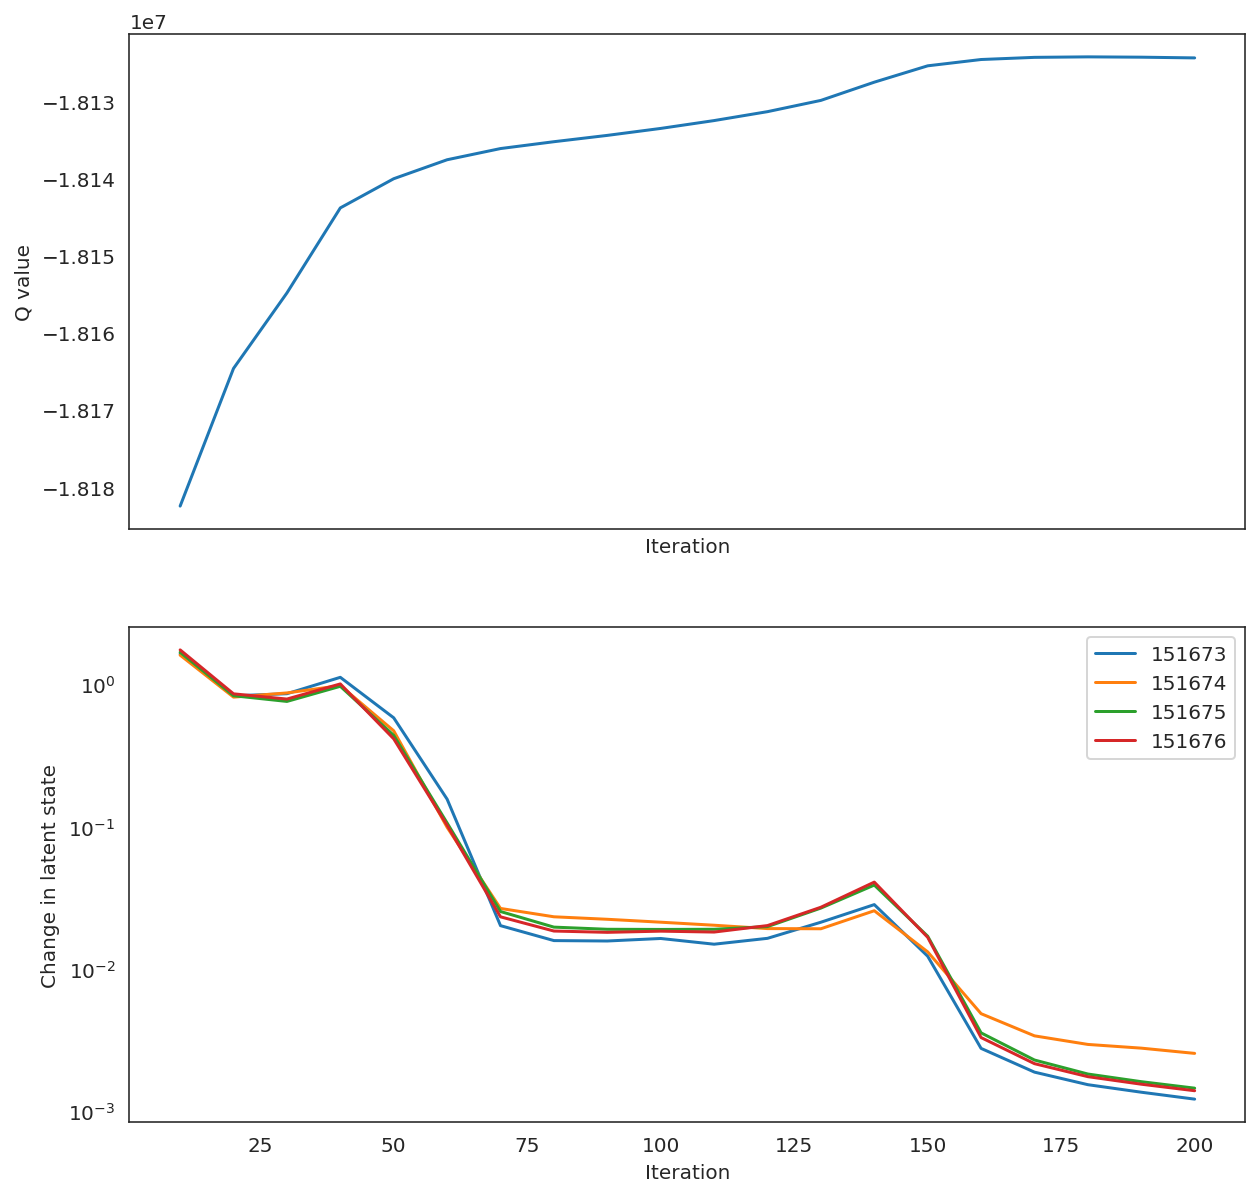

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
axes[0].plot(iter_list, Q_values.values())
axes[0].set(xlabel='Iteration', ylabel='Q value')
ax = axes[1]
for repli in repli_list:
    diff = np.fromiter([
        np.linalg.norm(latent_states[i, repli] - latent_states[j, repli], ord='fro')
        for i, j in zip(iter_list[:-1], iter_list[1:])], dtype=float)
    diff /= np.sqrt(np.prod(latent_states[0, repli].shape))
    ax.plot(iter_list[1:], diff, label=repli)
ax.legend()
ax.set(xlabel='Iteration', ylabel='Change in latent state', yscale='log')
plt.show()
plt.close()

In [8]:
for iiter in [200]:
    latent_state = np.concatenate([latent_states[iiter, repli] for repli in repli_list], axis=0)
    cluster = calculate_clustering(latent_state, df_meta, num_nbrs=20)
    evaluate_clusters(cluster, df_meta)

Louvain clustering: res=4.47e-01:   0%|          | 0/20 [00:00<?, ?it/s]

Louvain clustering: res=2.11e-01:   0%|          | 0/20 [00:00<?, ?it/s]

Louvain clustering: res=1.45e-01:   0%|          | 0/20 [00:00<?, ?it/s]

Louvain clustering: res=1.75e-01:   0%|          | 0/20 [00:00<?, ?it/s]

ari all = 0.64
ari 151673 = 0.64
ari 151674 = 0.63
ari 151675 = 0.66
ari 151676 = 0.69


## Part 2.2. Using the model trained in this notebook
Alternatively, if you run SpiceMix in this notebook, you may directly access learnt parameters through the SpiceMix object.

In [9]:
latent_states = [X.cpu().numpy() for X in obj.Xs]
latent_state_cat = np.concatenate(latent_states, axis=0)
cluster = calculate_clustering(latent_state_cat, df_meta, num_nbrs=20)
evaluate_clusters(cluster, df_meta)

Louvain clustering: res=4.47e-01:   0%|          | 0/20 [00:00<?, ?it/s]

Louvain clustering: res=2.11e-01:   0%|          | 0/20 [00:00<?, ?it/s]

Louvain clustering: res=1.45e-01:   0%|          | 0/20 [00:00<?, ?it/s]

Louvain clustering: res=1.75e-01:   0%|          | 0/20 [00:00<?, ?it/s]

ari all = 0.64
ari 151673 = 0.64
ari 151674 = 0.63
ari 151675 = 0.66
ari 151676 = 0.69
